<div style="text-align: right"> Kevin Le </div>
<div style="text-align: right"> CSE 803 </div>
<div style="text-align: right"> Hw6 </div>

## Import

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from utils import *
import open3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Camera Calibration

The goal is to compute the projection matrix P that goes from world 3D coordinates to 2D image coordinates. Recall that using homogeneous coordinates the equation for moving from 3D world to 2D camera
coordinates is:
$$
\begin{pmatrix}
u \\
v \\
1
\end{pmatrix} \equiv P

\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
$$

In part 1, you’re given corresponding point locations in pts2d-norm-pic.txt and pts3d-norm.txt,
which corresponds to a camera projection matrix. Solve the projection matrix P and include it in your report

Given 
$$
\begin{pmatrix}
u \\
v \\
1
\end{pmatrix} \equiv 
\begin{pmatrix}

P_{11} & P_{12} & P_{13} & P_{14} \\
P_{21} & P_{22} & P_{23} & P_{24}\\
P_{31} & P_{32} & P_{33} & P_{34}
\end{pmatrix}

\begin{pmatrix}
X \\
Y \\
Z \\
1
\end{pmatrix}
$$
Thus:
$$
\begin{bmatrix}
X_{1} & Y_{1} & Z_{1} & 1 & 0 & 0 & 0 & -u_{1}X_{1} & -u_{1}Y_{1} & -u_{1}Z_{1} & -u_{1} \\
0 & 0 & 0 & 0 & X_{1} & Y_{1} & Z_{1} & -v_{1}X_{1} & -v_{1}Y_{1} & -v_{1}Z_{1} & -v_{1} \\

... & ... & ... & ... & ... & ... & ... & ... & ... & ... & ...\\
X_{N} & Y_{N} & Z_{N} & 1 & 0 & 0 & 0 & -u_{N}X_{N} & -u_{N}Y_{N} & -u_{N}Z_{N} & -u_{N} \\
0 & 0 & 0 & 0 & X_{N} & Y_{N} & Z_{N} & -v_{N}X_{N} & -v_{N}Y_{N} & -v_{N}Z_{N} & -v_{N} \\
\end{bmatrix}_{2N \times 6}
\begin{bmatrix}
P_{11} \\ P_{12} \\ P_{13} \\
P_{21} \\ P_{22} \\ P_{23} \\
P_{31} \\ P_{32} \\ P_{33} \\
\end{bmatrix}
= 
\begin{bmatrix}
0 \\ 0 \\
... \\ 
0 \\ 0 \\
\end{bmatrix}
$$


In [2]:
p2d = np.loadtxt('./data/pts2d-norm-pic.txt')
p3d = np.loadtxt('./data/pts3d-norm.txt')

# Turn Homogenous
p2d = np.hstack((p2d, np.ones((p2d.shape[0], 1))))
p3d = np.hstack((p3d, np.ones((p3d.shape[0], 1))))

A = np.zeros((2*p2d.shape[0], 12))

for i in range(6):
    A[2*i] = np.array([p3d[i][0], p3d[i][1], p3d[i][2], 1, 0, 0, 0, 0, \
            -1 * p2d[i][0] * p3d[i][0], -1 * p2d[i][0] * p3d[i][1], \
                -1 * p2d[i][0] * p3d[i][2], -1 * p2d[i][0]])
    A[2*i + 1] = np.array([0, 0, 0, 0, p3d[i][0], p3d[i][1], p3d[i][2], \
        1, -1 * p2d[i][1] * p3d[i][0], -1 * p2d[i][1] * p3d[i][1], \
            -1 * p2d[i][1] * p3d[i][2], -1 * p2d[i][1]])

eig_val, eig_vec = np.linalg.eig(A.T @ A)
P = eig_vec[:,np.argmin(eig_val)].reshape(3,4)
print(P)

[[ 0.460996   -0.29451331 -0.00297082 -0.00135929]
 [-0.0507238  -0.05488378 -0.54314532 -0.05294097]
 [ 0.10916895  0.17962108 -0.03105869  0.59345849]]


Thus, 
$$
P =
\begin{bmatrix}
0.460996 & -0.29451331 & -0.00297082 & -0.00135929 \\
-0.0507238 & -0.05488378 & -0.54314532 & -0.05294097 \\
0.10916895 & 0.17962108 & -0.03105869 & 0.59345849]
\end{bmatrix}
$$

## Estimation of the Fundamental Matrix

The next part of this project is estimating the mapping of points in one image to lines in another by means
of the fundamental matrix. This will require you to use similar methods to those in part 1. You’ll work on
the Wizarding Temple dataset. 

Recall that the definition of the Fundamental Matrix is:
$$
\begin{pmatrix} u^{\prime} & v^{\prime} & 1 \end{pmatrix} 
\begin{pmatrix} 
f_{11} + f_{12} + f_{13} \\
f_{21} + f_{22} + f_{23} \\
f_{31} + f_{32} + f_{33} \\
\end{pmatrix} = 0
$$

Here are detailed instructions:
1. Load corresponding points from temple.npz.
2. Implement eight-point algorithm and estimate the fundamental matrix F. **Report** F in your report. Remember to normalize F so that the last entry of F is 1. Hint: You should normalize the
data first. For example, scale the data by dividing each coordinate by the maximum of the images width and height. You may validate your implementation by comparing against the output of
cv2.findFundamentalMat, **but you will be graded on your eight-point algorithm**.
3. Show epipolar lines. **Include** the visualization in your report. A sample output is shown as Figure
2. You can call draw epipolar(img1, img2, F, pts1, pts2) in utils.py to generate an image like the sample output. Note that you only need to show around 10 points and their
corresponding epipolar lines so that we can verify your calculation is correct.

Given: 
$$
\begin{pmatrix} u^{\prime} & v^{\prime} & 1 \end{pmatrix} 
\begin{pmatrix} 
f_{11} + f_{12} + f_{13} \\
f_{21} + f_{22} + f_{23} \\
f_{31} + f_{32} + f_{33} \\
\end{pmatrix} = 0
$$
  
$$
0 =
\begin{pmatrix} 
u * u^{\prime}, u * v^{\prime}, u, v * u^{\prime}, v * v^{\prime}, v, u^{\prime}, v^{\prime}, 1
\end{pmatrix}_{N}
\begin{pmatrix} 
f_{11} \\ f_{12} \\ f_{13} \\
f_{21} \\ f_{22} \\ f_{23} \\
f_{31} \\ f_{32} \\ f_{33} \\
\end{pmatrix}
$$

Fundamental Matrix: 
[[-4.18627784e-07  1.53757714e-05 -3.77154368e-03]
 [ 1.35855512e-05  3.07896251e-07  1.65206396e-01]
 [ 1.28555043e-03 -1.70633139e-01  1.00000000e+00]]


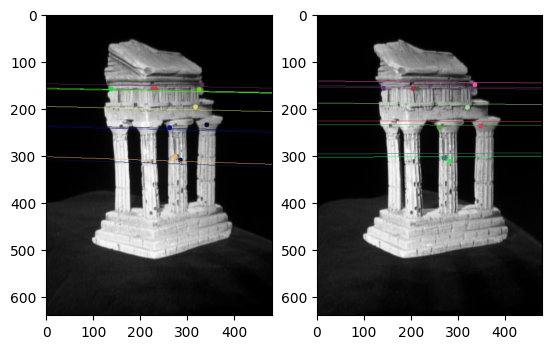

In [3]:
# Load Data
temple_data = np.load("data/temple.npz")
pt1 = temple_data['pts1']
pt2 = temple_data['pts2']

# Make Homogenous
p1 = np.hstack((pt1, np.ones((pt1.shape[0], 1)))).astype(float)
p2 = np.hstack((pt2, np.ones((pt2.shape[0], 1)))).astype(float)

# Normalize
n1 = np.array([
    [np.sqrt(2), 0, 0], 
    [0, np.sqrt(2), 0],
    [-np.mean(p1), -np.mean(p1), np.std(p1)]
]) / np.std(p1)
n2 = np.array([
    [np.sqrt(2), 0, 0], 
    [0, np.sqrt(2), 0],
    [-np.mean(p2), -np.mean(p2), np.std(p2)]
]) / np.std(p2)

p1 = p1 @ n1
p2 = p2 @ n2

# Create U matrix
U = np.zeros((p1.shape[0], 9))
for i in range(p1.shape[0]):
    u1, v1 = p1[i][0], p1[i][1]
    u2, v2 = p2[i][0], p2[i][1]
    U[i] = np.array([
        u1 * u2, u1 * v2, u1, 
        v1 * u2, v1 * v2, v1,
        u2, v2, 1
    ])

# 8 point Algorithm
eig_val, eig_vec = np.linalg.eig(U.T @ U)
f = eig_vec[:,np.argmin(eig_val)].reshape(3,3)
U_, S, V = np.linalg.svd(f)
S = np.diag(S)
S[2][2] = 0
F = U_ @ S @ V
F = n2 @ F @ n1.T
F /= F[2][2]
print(f"Fundamental Matrix: \n{F}")

# Plot
i1 = cv2.cvtColor(cv2.imread('./data/im1.png'), cv2.COLOR_BGR2GRAY)
i2 = cv2.cvtColor(cv2.imread('./data/im2.png'), cv2.COLOR_BGR2GRAY)
draw_epipolar(i1, i2, F, pt1[:10], pt2[:10])

## Triangulation

The next step is extracting 3D points from 2D points and camera matrices, which is called triangulation. Let
$X = (X_{1}, X_{2}, X_{3}, 1)^{T}$ be a point in 3D. For two cameras, we have
$$
x_{1} = P_{1}X \\
x_{2} = P_{2}X
$$
Triangulation is to solve X given x1, x2, P1, P2. We’ll use Direct Linear Transform (DLT) to perform triangulation, which has already been implemented in OpenCV.

Here are the instructions:
1. Load camera intrinsic matrix $K_{1}$ and $K_{2}$ from temple.npz.
2. Extract the essential matrix E given the fundamental matrix F and intrinsic matrices $K_{1}$ and $K_{2}$.
Report E. For this question, you may use cv2.findFundamentalMat to obtain the Fundamental matrix. Recall that
$$
F = K^{−T}_{2} EK^{−1}_{1}
$$

3. Decompose the essential matrix E and get the rotation matrix R and translation t. You can use
cv2.decomposeEssentialMat. Hint: There are four possible combinations of R and t. The
correct configuration is the one for which most of the 3D points are in front of both cameras (positive
depth).
4. Determine the camera projection matrices P1 and P2 according to the intrinsic and extrinsic matrix
[R|t], K1 and K2. Report P1 and P2. You can set
$$
P_{1} = K_{1}[I\quad 0] \\
P_{2} = K_{2}[R\quad t]
$$
5. Triangulate 2D pairs of points to 3D. You can use cv2.triangulatePoints.
6. Visualize the point cloud. **Include** the visualization in your report from at least 3 views (so that we
can reconstruct it!). A sample output is shown as Figure 3. You may use our provided visualization
function, visualize pcd found in utils.py, or you can implement your own visualization. One
good alternative is matplotlib’s 3D scatterplot.


In [4]:
k1 = temple_data["K1"]
k2 = temple_data["K2"]
F, _ = cv2.findFundamentalMat(pt1, pt2, cv2.FM_8POINT)
E = k2.T @ F @ k1
print(f"Essential Matrix: \n {E}")

Essential Matrix: 
 [[  -1.0551774    56.42814506    9.17409425]
 [  35.84410427    1.31422261 -351.3790752 ]
 [  -0.79493824  355.80639208    0.42113092]]


In [5]:
r1, r2, t = cv2.decomposeEssentialMat(E)

I = np.hstack((np.identity(3), np.zeros((3,1))))
RT = np.hstack((r1, t))

P1 = k1 @ I
P2 = k2 @ RT
print(F"Projection Matrix 1: \n {P1}")
print(F"Projection Matrix 2: \n {P2}")


Projection Matrix 1: 
 [[1.5204e+03 0.0000e+00 3.0230e+02 0.0000e+00]
 [0.0000e+00 1.5259e+03 2.4690e+02 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00]]
Projection Matrix 2: 
 [[ 1.39186153e+03 -3.66057834e+01  6.81456482e+02  1.45375608e+03]
 [-2.82826215e+01  1.52525962e+03  2.49226019e+02  3.64493323e-01]
 [-2.56102739e-01 -8.24379544e-04  9.66649216e-01 -1.56675614e-01]]


In [6]:
tri = cv2.triangulatePoints(P1, P2, pt1.T.astype(float), pt2.T.astype(float))

# Homogeneous to Cartisian
tri /= tri[3]
visualize_pcd(tri[:3].T)

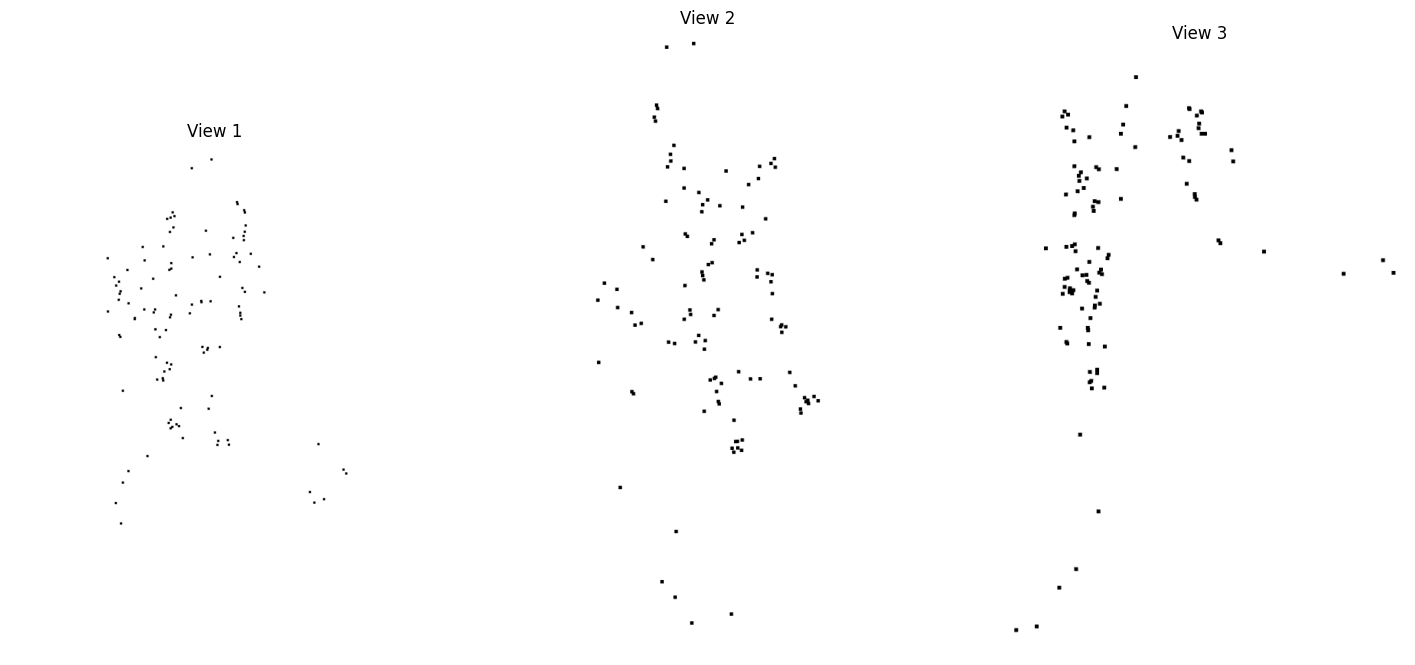

In [19]:
v1 = plt.imread("view1.png")
v2 = plt.imread("view2.png")
v3 = plt.imread("view3.png")
v4 = plt.imread("view4.png")
v5 = plt.imread("view5.png")

f = plt.figure()
f.add_subplot(1,3, 1)
plt.imshow(v1)
plt.axis("off")
plt.title("View 1")
f.add_subplot(1,3, 2)
plt.imshow(v2)
plt.axis("off")
plt.title("View 2")
f.add_subplot(1,3, 3)
plt.imshow(v3)
plt.axis("off")
plt.title("View 3")
plt.gcf().set_size_inches(18, 10)


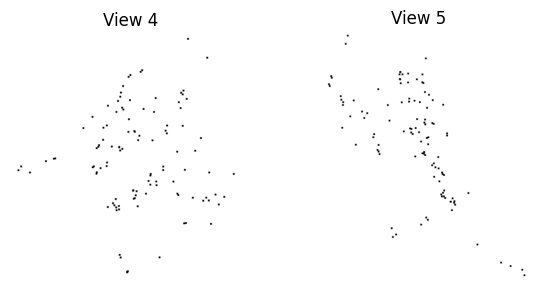

In [21]:
f = plt.figure()
f.add_subplot(1,5, 4)
plt.imshow(v4)
plt.axis("off")
plt.title("View 4")
f.add_subplot(1,5, 5)
plt.imshow(v5)
plt.axis("off")
plt.title("View 5")
plt.gcf().set_size_inches(18, 10)